In [7]:
!pip install hyperopt

  Using cached hyperopt-0.2.7-py2.py3-none-any.whl (1.6 MB)
     |████████████████████████████████| 199 kB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 829 kB 1.5 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 10.4 MB/s eta 0:00:01
  Using cached cloudpickle-2.1.0-py3-none-any.whl (25 kB)
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=ac71af753f3c1160c6a0b3f5007c35795d87af60b0b217ad8b4d6a86beacf5a8
  Stored in directory: /Users/przivic/Library/Caches/pip/wheels/2f/a0/d3/4030d9f80e6b3be787f19fc911b8e7aa462986a40ab1e4bb94
Successfully built future


In [1]:
!pip install --upgrade --force lightgbm

  Using cached lightgbm-3.3.2-py3-none-macosx_10_14_x86_64.macosx_10_15_x86_64.macosx_11_0_x86_64.whl (1.2 MB)
     |████████████████████████████████| 18.1 MB 5.4 MB/s eta 0:00:01
  Using cached scipy-1.8.1-cp39-cp39-macosx_12_0_universal2.macosx_10_9_x86_64.whl (55.6 MB)
^C
ERROR: Operation cancelled by user


In [1]:
import pandas as pd

import sys
sys.path.append('../../lib')

In [2]:
from taller_model_selection.evaluate import load_train_dev_test

(X_train, y_train), (X_dev, y_dev), test = load_train_dev_test('.')

{'pct(train)': 0.7837289649483001, 'pct(dev)': 0.11952685477518159, 'pct(test)': 0.09674418027651828}


In [3]:
from taller_model_selection.metrics import rmse
from taller_model_selection.transformers import FeatureProjection
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

features_pipe = make_union(
    make_pipeline(
        FeatureProjection(['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']),
        SimpleImputer()
    ),
    make_pipeline(
        FeatureProjection(['l3']), 
        SimpleImputer(strategy='most_frequent'),
        OneHotEncoder(sparse=False)
    ), 
    make_pipeline(
        FeatureProjection(['l4']), 
        SimpleImputer(strategy='constant'),
        OneHotEncoder(sparse=False)
    ), 
)

In [4]:
import lightgbm as lgb
from pprint import pprint
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from time import time

def eval_pipe(model_name, pipe):
    return dict(
        name=model_name,
        train=rmse(y_train, pipe.predict(X_train)),
        dev=rmse(y_dev, pipe.predict(X_dev))
    )

def objective(params):
    params['n_estimators'] = int(params['n_estimators'])
    print(params)
    pipe = make_pipeline(
        features_pipe,
        lgb.LGBMRegressor(random_state=42, **params)
    )
    t0 = time()
    pipe.fit(X_train, y_train)
    train_time = time() - t0
    loss=rmse(y_dev, pipe.predict(X_dev))
    print(f'loss {loss:.02f}')
    return dict(
        loss=loss,
        tr_loss=rmse(y_train, pipe.predict(X_train)), 
        params=params,
        train_time=train_time,
        status=STATUS_OK
    )

In [5]:
import numpy as np

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 3000, 10),
    'subsample': hp.quniform('subsample', 0.5, 1.0, 0.1),
    'objective': hp.choice('objective', ["regression", "regression_l1"]),
    'learning_rate': hp.qloguniform('learning_rate', np.log(0.01), np.log(0.3), 0.01),
    'reg_alpha': hp.choice('ra', [0, hp.quniform('reg_alpha', 0.01, 0.1, 0.01)]),
}

trials = Trials()

In [6]:
best = fmin(objective, space, algo=tpe.suggest, max_evals=1000, trials=trials)

{'learning_rate': 0.27, 'n_estimators': 2050, 'objective': 'regression_l1', 'reg_alpha': 0, 'subsample': 0.7000000000000001}
loss 297491.03                                                                  
{'learning_rate': 0.18, 'n_estimators': 1980, 'objective': 'regression_l1', 'reg_alpha': 0.06, 'subsample': 0.5}
loss 297508.31                                                                  
{'learning_rate': 0.02, 'n_estimators': 1530, 'objective': 'regression', 'reg_alpha': 0.09, 'subsample': 0.6000000000000001}
loss 282722.61                                                                  
{'learning_rate': 0.02, 'n_estimators': 290, 'objective': 'regression', 'reg_alpha': 0.07, 'subsample': 0.7000000000000001}
loss 288252.66                                                                  
{'learning_rate': 0.07, 'n_estimators': 2850, 'objective': 'regression_l1', 'reg_alpha': 0.06, 'subsample': 0.6000000000000001}
loss 295902.03                                               

loss 392564.85                                                                  
{'learning_rate': 0.05, 'n_estimators': 940, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.7000000000000001}
loss 281965.07                                                                  
{'learning_rate': 0.07, 'n_estimators': 490, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.8}
loss 282644.41                                                                  
{'learning_rate': 0.15, 'n_estimators': 1360, 'objective': 'regression_l1', 'reg_alpha': 0, 'subsample': 0.9}
loss 294494.53                                                                  
{'learning_rate': 0.05, 'n_estimators': 1110, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 1.0}
loss 281725.71                                                                  
{'learning_rate': 0.04, 'n_estimators': 800, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.7000000000000001}
loss 283013.52                

{'learning_rate': 0.04, 'n_estimators': 1850, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 1.0}
loss 282394.55                                                                  
{'learning_rate': 0.11, 'n_estimators': 1700, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.9}
loss 282817.28                                                                  
{'learning_rate': 0.06, 'n_estimators': 2210, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 1.0}
loss 280919.83                                                                  
{'learning_rate': 0.06, 'n_estimators': 1540, 'objective': 'regression', 'reg_alpha': 0.07, 'subsample': 0.9}
loss 281113.94                                                                  
{'learning_rate': 0.2, 'n_estimators': 1790, 'objective': 'regression_l1', 'reg_alpha': 0, 'subsample': 0.9}
loss 294407.54                                                                  
{'learning_rate': 0.07, 'n_estimators': 2260, 'objectiv

loss 282226.84                                                                  
{'learning_rate': 0.08, 'n_estimators': 170, 'objective': 'regression', 'reg_alpha': 0.1, 'subsample': 0.8}
loss 285597.50                                                                  
{'learning_rate': 0.14, 'n_estimators': 1240, 'objective': 'regression_l1', 'reg_alpha': 0, 'subsample': 0.9}
loss 294959.68                                                                  
{'learning_rate': 0.12, 'n_estimators': 1580, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 1.0}
loss 283724.83                                                                  
{'learning_rate': 0.04, 'n_estimators': 2530, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.8}
loss 282203.82                                                                  
{'learning_rate': 0.22, 'n_estimators': 1850, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.9}
loss 284862.29                                          

loss 282574.56                                                                  
{'learning_rate': 0.13, 'n_estimators': 2210, 'objective': 'regression', 'reg_alpha': 0.08, 'subsample': 0.9}
loss 284234.38                                                                  
{'learning_rate': 0.15, 'n_estimators': 1760, 'objective': 'regression_l1', 'reg_alpha': 0, 'subsample': 1.0}
loss 294095.44                                                                  
{'learning_rate': 0.03, 'n_estimators': 1690, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.9}
loss 282137.26                                                                  
{'learning_rate': 0.12, 'n_estimators': 2420, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 1.0}
loss 284872.88                                                                  
{'learning_rate': 0.07, 'n_estimators': 2890, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.9}
loss 281658.17                                        

loss 295749.22                                                                  
{'learning_rate': 0.12, 'n_estimators': 890, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 1.0}
loss 283693.12                                                                  
{'learning_rate': 0.06, 'n_estimators': 1770, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.9}
loss 281550.37                                                                  
{'learning_rate': 0.01, 'n_estimators': 1910, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.6000000000000001}
loss 284373.08                                                                  
{'learning_rate': 0.22, 'n_estimators': 970, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 1.0}
loss 283752.47                                                                  
{'learning_rate': 0.03, 'n_estimators': 2700, 'objective': 'regression', 'reg_alpha': 0.06, 'subsample': 0.9}
loss 282010.96                              

loss 301561.37                                                                  
{'learning_rate': 0.25, 'n_estimators': 810, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.8}
loss 286187.39                                                                  
{'learning_rate': 0.08, 'n_estimators': 1510, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.7000000000000001}
loss 280250.35                                                                  
{'learning_rate': 0.08, 'n_estimators': 1280, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.7000000000000001}
loss 280438.88                                                                  
{'learning_rate': 0.1, 'n_estimators': 1280, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.7000000000000001}
loss 283222.42                                                                  
{'learning_rate': 0.08, 'n_estimators': 1040, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.7000000000000001}
lo

{'learning_rate': 0.11, 'n_estimators': 1740, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.7000000000000001}
loss 282725.40                                                                  
{'learning_rate': 0.12, 'n_estimators': 1610, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.6000000000000001}
loss 283803.54                                                                  
{'learning_rate': 0.04, 'n_estimators': 1460, 'objective': 'regression', 'reg_alpha': 0.04, 'subsample': 0.7000000000000001}
loss 282249.25                                                                  
{'learning_rate': 0.09, 'n_estimators': 1350, 'objective': 'regression_l1', 'reg_alpha': 0, 'subsample': 0.7000000000000001}
loss 293862.23                                                                  
{'learning_rate': 0.03, 'n_estimators': 1510, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.7000000000000001}
loss 282591.96                                              

loss 285168.96                                                                  
{'learning_rate': 0.01, 'n_estimators': 1060, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.8}
loss 285462.56                                                                  
{'learning_rate': 0.07, 'n_estimators': 1820, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.8}
loss 281686.03                                                                  
{'learning_rate': 0.05, 'n_estimators': 1520, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.8}
loss 281782.71                                                                  
{'learning_rate': 0.17, 'n_estimators': 1700, 'objective': 'regression', 'reg_alpha': 0.1, 'subsample': 0.8}
loss 282481.22                                                                  
{'learning_rate': 0.09, 'n_estimators': 1570, 'objective': 'regression_l1', 'reg_alpha': 0, 'subsample': 0.8}
loss 293709.06                                         

{'learning_rate': 0.03, 'n_estimators': 1850, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.8}
loss 281972.78                                                                  
{'learning_rate': 0.05, 'n_estimators': 740, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.7000000000000001}
loss 282608.16                                                                  
{'learning_rate': 0.04, 'n_estimators': 1480, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.6000000000000001}
loss 282233.77                                                                  
{'learning_rate': 0.11, 'n_estimators': 1340, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.8}
loss 282516.19                                                                  
{'learning_rate': 0.1, 'n_estimators': 1580, 'objective': 'regression', 'reg_alpha': 0.08, 'subsample': 0.7000000000000001}
loss 281959.10                                                                  
{'learning_rat

loss 281871.38                                                                  
{'learning_rate': 0.08, 'n_estimators': 1850, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.7000000000000001}
loss 280532.02                                                                  
{'learning_rate': 0.07, 'n_estimators': 1470, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.7000000000000001}
loss 281647.74                                                                  
{'learning_rate': 0.06, 'n_estimators': 1710, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.8}
loss 281566.48                                                                  
{'learning_rate': 0.12, 'n_estimators': 1280, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.6000000000000001}
loss 283994.56                                                                  
{'learning_rate': 0.1, 'n_estimators': 1400, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.7000000000000001}
l

loss 281886.45                                                                  
{'learning_rate': 0.07, 'n_estimators': 1210, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.8}
loss 281693.85                                                                  
{'learning_rate': 0.05, 'n_estimators': 1740, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.8}
loss 282360.54                                                                  
{'learning_rate': 0.08, 'n_estimators': 1630, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.8}
loss 280370.89                                                                  
{'learning_rate': 0.12, 'n_estimators': 1570, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.8}
loss 283700.62                                                                  
{'learning_rate': 0.09, 'n_estimators': 1400, 'objective': 'regression', 'reg_alpha': 0.04, 'subsample': 0.8}
loss 282106.16                                           

{'learning_rate': 0.04, 'n_estimators': 2210, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.7000000000000001}
loss 282549.10                                                                  
{'learning_rate': 0.11, 'n_estimators': 930, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.8}
loss 282193.86                                                                  
{'learning_rate': 0.1, 'n_estimators': 1940, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.7000000000000001}
loss 282070.77                                                                  
{'learning_rate': 0.08, 'n_estimators': 1730, 'objective': 'regression', 'reg_alpha': 0.09, 'subsample': 0.8}
loss 281324.86                                                                  
{'learning_rate': 0.09, 'n_estimators': 1410, 'objective': 'regression_l1', 'reg_alpha': 0, 'subsample': 0.7000000000000001}
loss 293704.60                                                                  
{'learning_

{'learning_rate': 0.09, 'n_estimators': 1720, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.8}
loss 281904.03                                                                  
{'learning_rate': 0.15, 'n_estimators': 1640, 'objective': 'regression', 'reg_alpha': 0.07, 'subsample': 0.9}
loss 282477.37                                                                  
{'learning_rate': 0.08, 'n_estimators': 1600, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.8}
loss 280406.40                                                                  
{'learning_rate': 0.13, 'n_estimators': 2560, 'objective': 'regression_l1', 'reg_alpha': 0, 'subsample': 0.7000000000000001}
loss 297678.03                                                                  
{'learning_rate': 0.05, 'n_estimators': 2140, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.8}
loss 281822.16                                                                  
{'learning_rate': 0.06, 'n_estimators':

loss 281658.91                                                                  
{'learning_rate': 0.09, 'n_estimators': 1210, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.8}
loss 281589.08                                                                  
{'learning_rate': 0.06, 'n_estimators': 1470, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.8}
loss 281873.91                                                                  
{'learning_rate': 0.12, 'n_estimators': 1420, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.8}
loss 284183.44                                                                  
{'learning_rate': 0.07, 'n_estimators': 1320, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.8}
loss 281990.61                                                                  
{'learning_rate': 0.1, 'n_estimators': 1600, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.8}
loss 282576.43                                               

{'learning_rate': 0.14, 'n_estimators': 1440, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.8}
loss 283112.14                                                                  
{'learning_rate': 0.08, 'n_estimators': 1590, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.8}
loss 280403.77                                                                  
{'learning_rate': 0.1, 'n_estimators': 1700, 'objective': 'regression', 'reg_alpha': 0.01, 'subsample': 0.8}
loss 281886.45                                                                  
{'learning_rate': 0.09, 'n_estimators': 1170, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.8}
loss 281591.37                                                                  
{'learning_rate': 0.05, 'n_estimators': 1840, 'objective': 'regression_l1', 'reg_alpha': 0, 'subsample': 0.8}
loss 295619.45                                                                  
{'learning_rate': 0.06, 'n_estimators': 1490, 'objectiv

{'learning_rate': 0.09, 'n_estimators': 1440, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.7000000000000001}
loss 282128.68                                                                  
{'learning_rate': 0.05, 'n_estimators': 1650, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.7000000000000001}
loss 281840.34                                                                  
{'learning_rate': 0.06, 'n_estimators': 1310, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.6000000000000001}
loss 282540.86                                                                  
{'learning_rate': 0.08, 'n_estimators': 1540, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.7000000000000001}
loss 280161.36                                                                  
{'learning_rate': 0.07, 'n_estimators': 1980, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.7000000000000001}
loss 281417.33                                                    

loss 283350.75                                                                  
{'learning_rate': 0.1, 'n_estimators': 1920, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.7000000000000001}
loss 282323.66                                                                  
{'learning_rate': 0.09, 'n_estimators': 1720, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.7000000000000001}
loss 281904.03                                                                  
{'learning_rate': 0.06, 'n_estimators': 1330, 'objective': 'regression', 'reg_alpha': 0.03, 'subsample': 0.6000000000000001}
loss 281247.45                                                                  
{'learning_rate': 0.07, 'n_estimators': 1210, 'objective': 'regression_l1', 'reg_alpha': 0, 'subsample': 0.7000000000000001}
loss 298278.57                                                                  
{'learning_rate': 0.12, 'n_estimators': 1640, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 

loss 284143.60                                                                  
{'learning_rate': 0.06, 'n_estimators': 2150, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.9}
loss 280882.51                                                                  
{'learning_rate': 0.08, 'n_estimators': 1550, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.9}
loss 280079.23                                                                  
{'learning_rate': 0.1, 'n_estimators': 1840, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 1.0}
loss 282266.33                                                                  
{'learning_rate': 0.05, 'n_estimators': 2780, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 1.0}
loss 281361.97                                                                  
{'learning_rate': 0.08, 'n_estimators': 2070, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 1.0}
loss 280667.99                                               

{'learning_rate': 0.11, 'n_estimators': 1730, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.9}
loss 282563.62                                                                  
{'learning_rate': 0.1, 'n_estimators': 1390, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.9}
loss 282921.40                                                                  
{'learning_rate': 0.07, 'n_estimators': 1620, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.9}
loss 281613.67                                                                  
{'learning_rate': 0.06, 'n_estimators': 1470, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.9}
loss 281873.91                                                                  
{'learning_rate': 0.09, 'n_estimators': 1300, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 1.0}
loss 281622.06                                                                  
{'learning_rate': 0.08, 'n_estimators': 1360, 'objective': 'r

loss 282268.05                                                                  
{'learning_rate': 0.11, 'n_estimators': 1730, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 1.0}
loss 282563.62                                                                  
{'learning_rate': 0.09, 'n_estimators': 1180, 'objective': 'regression_l1', 'reg_alpha': 0, 'subsample': 0.9}
loss 293966.87                                                                  
{'learning_rate': 0.12, 'n_estimators': 1490, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.9}
loss 283453.73                                                                  
{'learning_rate': 0.07, 'n_estimators': 1640, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.9}
loss 281542.42                                                                  
{'learning_rate': 0.06, 'n_estimators': 1310, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.9}
loss 282540.86                                           

{'learning_rate': 0.13, 'n_estimators': 1380, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.9}
loss 283314.31                                                                  
{'learning_rate': 0.09, 'n_estimators': 1570, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.9}
loss 282091.41                                                                  
{'learning_rate': 0.11, 'n_estimators': 1640, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.9}
loss 282768.87                                                                  
{'learning_rate': 0.07, 'n_estimators': 1320, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 1.0}
loss 281990.61                                                                  
{'learning_rate': 0.08, 'n_estimators': 2020, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.9}
loss 280623.84                                                                  
{'learning_rate': 0.1, 'n_estimators': 1670, 'objective': 'r

loss 280406.40                                                                  
{'learning_rate': 0.11, 'n_estimators': 1210, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.9}
loss 283315.98                                                                  
{'learning_rate': 0.05, 'n_estimators': 1500, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.9}
loss 281758.67                                                                  
{'learning_rate': 0.1, 'n_estimators': 1680, 'objective': 'regression', 'reg_alpha': 0.05, 'subsample': 1.0}
loss 281700.26                                                                  
{'learning_rate': 0.09, 'n_estimators': 1070, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.9}
loss 281700.85                                                                  
{'learning_rate': 0.06, 'n_estimators': 1850, 'objective': 'regression_l1', 'reg_alpha': 0, 'subsample': 0.9}
loss 296556.88                                         

{'learning_rate': 0.05, 'n_estimators': 1070, 'objective': 'regression', 'reg_alpha': 0.09, 'subsample': 0.9}
loss 281726.29                                                                  
{'learning_rate': 0.06, 'n_estimators': 1470, 'objective': 'regression_l1', 'reg_alpha': 0, 'subsample': 0.9}
loss 296545.52                                                                  
{'learning_rate': 0.09, 'n_estimators': 1140, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.9}
loss 281703.79                                                                  
{'learning_rate': 0.04, 'n_estimators': 1290, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 0.9}
loss 282403.28                                                                  
{'learning_rate': 0.08, 'n_estimators': 1380, 'objective': 'regression', 'reg_alpha': 0, 'subsample': 1.0}
loss 280475.59                                                                  
{'learning_rate': 0.07, 'n_estimators': 1490, 'objecti

In [10]:
import pickle as pkl
1/0
with open('trials.pkl', 'wb') as f:
    pkl.dump(trials, f)

In [5]:
import pickle as pkl

with open('trials.pkl', 'rb') as f:
    trials = pkl.load(f)

In [11]:
def flatten(doc, pref=''):
    res = {}
    for k, v in doc.items():
        k = f'{pref}.{k}' if pref else k
        if isinstance(v, dict):
            res.update(flatten(v, k))
        else:
            res[k] = v
    return res

In [12]:
import pandas as pd
df = pd.DataFrame(list(map(flatten, [e['result'] for e in trials.trials])))
df.sort_values('loss').head()

,loss,tr_loss,params.learning_rate,params.n_estimators,params.objective,params.reg_alpha,params.subsample,train_time,status
990,280079.22661,253562.038765,0.08,1550,regression,0.0,0.9,3.387196,ok
402,280079.22661,253562.038765,0.08,1550,regression,0.0,0.7,3.414878,ok
791,280079.22661,253562.038765,0.08,1550,regression,0.0,0.9,3.387109,ok
759,280079.22661,253562.038765,0.08,1550,regression,0.0,0.9,3.359970,ok
786,280079.22661,253562.038765,0.08,1550,regression,0.0,0.9,3.531488,ok


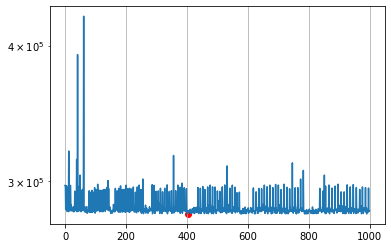

In [13]:
import matplotlib.pyplot as plt

df.loss.plot()
plt.scatter([df.loss.argmin()], [df.loss.min()], c='r')
# df.tr_loss.plot()
plt.yscale('log')
plt.grid()

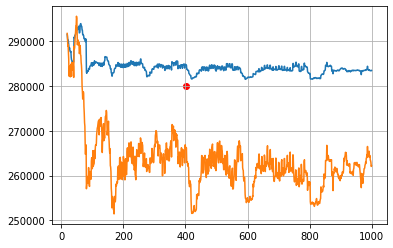

In [14]:

df.loss.rolling(20).mean().plot()
plt.scatter([df.loss.argmin()], [df.loss.min()], c='r')
df.tr_loss.rolling(20).mean().plot()
plt.grid()

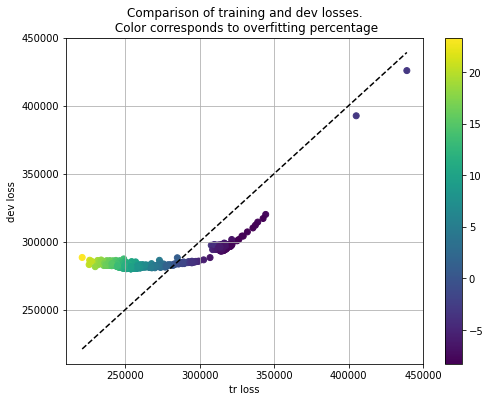

In [15]:
plt.figure(figsize=(8,6))
plt.scatter(df.tr_loss, df.loss, c=(df.loss-df.tr_loss)/df.loss*100)
plt.title('Comparison of training and dev losses.\n Color corresponds to overfitting percentage')
plt.colorbar()
m = min(df.tr_loss.min(), df.loss.min())
M = max(df.tr_loss.max(), df.loss.max())
plt.plot([m, M], [m, M], 'k--')
plt.xlabel('tr loss')
plt.ylabel('dev loss')
plt.grid()

In [17]:
best = df[df.loss < df.loss.min() * 1.001].sort_values('tr_loss', ascending=False).head(30)
best

,loss,tr_loss,params.learning_rate,params.n_estimators,params.objective,params.reg_alpha,params.subsample,train_time,status
77,299221.864446,235478.103361,0.14,1460,regression,0.00,1.0,3.260258,ok
289,299083.208546,233732.075608,0.14,1610,regression,0.00,1.0,3.511403,ok
117,299151.785484,233138.195638,0.14,1670,regression,0.00,1.0,3.728529,ok
147,299161.054625,232546.925179,0.14,1730,regression,0.00,1.0,3.837287,ok
257,299161.054625,232546.925179,0.14,1730,regression,0.00,1.0,3.621785,ok
500,299183.581488,232309.084073,0.13,1920,regression,0.05,0.8,4.071576,ok
73,299102.303181,232090.719539,0.14,1780,regression,0.00,1.0,3.647600,ok
712,299168.587297,231548.172805,0.13,2000,regression,0.05,0.8,4.122056,ok
559,299183.105988,231363.701008,0.13,2020,regression,0.06,0.9,7.445719,ok
985,299113.721006,231260.397753,0.13,2030,regression,0.03,0.7,4.143197,ok


In [19]:
X_test, y_test = test

In [20]:
params = {k.replace('params.', ''):v for k, v in best.iloc[0].to_dict().items() if 'params.' in k}
rf_pipe = make_pipeline(
    features_pipe,
    lgb.LGBMRegressor(random_state=42, **params)
)
rf_pipe.fit(X_train, y_train)

best_model_performance = dict(
    tr_loss=rmse(y_train, rf_pipe.predict(X_train)), 
    dev_loss=rmse(y_dev, rf_pipe.predict(X_dev)),
    test_loss=rmse(y_test, rf_pipe.predict(X_test)), 
)
best_model_performance

{'tr_loss': 243758.34842441877,
 'dev_loss': 283105.2058477523,
 'test_loss': 228476.032745023}